<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_GAN/blob/master/CGAN_no_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow==2.1
# https://medium.com/@mafda_/gans-conditional-gans-with-mnist-part-4-7f816d274d8c

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Lambda, ReLU, Input, concatenate, InputLayer, Flatten, Conv2D, Dense, BatchNormalization, Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential, optimizers, metrics

import matplotlib.pyplot as plt

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

In [3]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [4]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [5]:
x_train.shape

(60000, 28, 28, 1)

In [6]:
batch_size = 256
noise_dim = 100
lr = 1e-4

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
type(train_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [8]:
class CGAN(keras.Model):

  def __init__(self, **kwargs):
    super(CGAN, self).__init__()
    self.__dict__.update(kwargs)

    self.generator = Sequential(self.gen_nn)    
    self.discriminator = Sequential(self.dis_nn)
    self.cross_entropy = self.cross_entropy
    self.noise_z = self.noise

  def Generator(self, x, condition, training):
    input = concatenate([x, condition])
    if training == True:
      gen = self.generator(input, training=True)
    else:
      gen = self.generator(input, training=False)
    return gen 

  def Discriminator(self, x, condition):
    # condition = Input(shape=(condition.shape[1],))  
    x = tf.reshape(x, [256, 784])
    input = concatenate([x, condition])

    dis = self.discriminator(input, training=True)
    return dis

  @tf.function
  def dis_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss

  @tf.function 
  def gen_loss(self, fake_output):
    loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

  @tf.function
  def compute_gradient(self, x, condition):
    noise = np.random.uniform(-1, 1, size=[batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
      generated_img = self.Generator(noise, condition, True)
                  
      real_output = self.Discriminator(x, condition)
      fake_output = self.Discriminator(generated_img, condition)
      
      '''TODO: (256, 1로 만들기)'''
      
      # fake_output = tf.convert_to_tensor(fake_output, dtype=tf.float32)

      loss_gen = self.gen_loss(fake_output)
      loss_dis = self.dis_loss(real_output, fake_output)

    gradient_gen = gen_tape.gradient(loss_gen, self.generator.trainable_variables)
    gradient_dis = dis_tape.gradient(loss_dis, self.discriminator.trainable_variables)

    return gradient_gen, gradient_dis, loss_gen, loss_dis

  @tf.function
  def train(self, x, condition):
    gradient_gen, gradient_dis, loss_gen, loss_dis = self.compute_gradient(x, condition)
    self.gen_optimizer.apply_gradients(zip(gradient_gen, self.generator.trainable_variables))
    self.dis_optimizer.apply_gradients(zip(gradient_dis, self.discriminator.trainable_variables))
    return loss_gen, loss_dis




In [9]:
gen_nn_Dense = [
                Dense(256, input_dim=110, activation='relu'),
                Dense(512, activation='relu'),
                Dense(1024, activation='relu'),
                Dense(784, activation='sigmoid'),
                Reshape((28,28,1))]

dis_nn_Dense = [
                # InputLayer(input_shape=(28, 28, 1)),
                # Reshape((-1, 784)),
                InputLayer(input_shape=(794)),
                Lambda(Reshape((-1, 794))),
                Dense(1024, input_dim=794),
                LeakyReLU(),
                Dropout(0.3),

                Dense(512),
                LeakyReLU(),
                Dropout(0.3),

                Dense(256),
                LeakyReLU(),
                Dropout(0.3),

                Flatten(),
                Dense(1)]

In [10]:
gen_optimizer = optimizers.Adam(0.001, beta_1=0.5)
dis_optimizer = optimizers.RMSprop(0.005)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
noise = tf.random.normal([batch_size, noise_dim])
noise_uni = np.random.uniform(-1, 1, size=[batch_size, noise_dim])

In [11]:
gen_network = CGAN(
    gen_nn=gen_nn_Dense, 
    dis_nn=dis_nn_Dense,
    noise=noise_uni,
    gen_optimizer=gen_optimizer,
    dis_optimizer=dis_optimizer,
    cross_entropy=cross_entropy)

In [12]:
gen_network.discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 794)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1024)           814080    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 1024)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1024)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 1, 512)            524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 512)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 512)           

In [13]:
train_gen_loss = metrics.Mean(name='train_generator_loss')
train_dis_loss = metrics.Mean(name='train_discriminator_loss')
test_gen_loss = metrics.Mean(name='test_generator_loss')
test_dis_loss = metrics.Mean(name='test_discriminator_loss')

In [14]:
def show_generated_img(model, epoch, test_data, label):
  predict = model.Generator(test_data, label, False)
  
  # label_print = 0

  # for i in range(len(label)):
  #   if label[i] == 1.0:
  #     label_print = i
  #   else:
  #     continue


  fig = plt.figure(figsize=(7, 7))

  for i in range(predict.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predict[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.title(f'{np.where(1 == label[i])}')
    plt.axis('off')

  plt.savefig(f'/content/drive/MyDrive/Colab/Graduation_paper/CGAN/gen_img/gen_img{epoch}.png')        
  plt.show()

In [15]:
def show_loss(gen, dis, tgen, tdis, epoch):

  plt.plot(epoch, gen, label='gen train')
    # plt.plot(epoch, tgen, label='gen test')
  plt.plot(epoch, dis, label='dis train')
    # plt.plot(epoch, tdis, label='dis test')
  plt.legend()
  plt.show()

Epoch: 0, Gen[train]: 22.968822479248047, Dis[train]: 21.689340591430664, Gen[test]: 0.0, Dis[test]: 0.0 


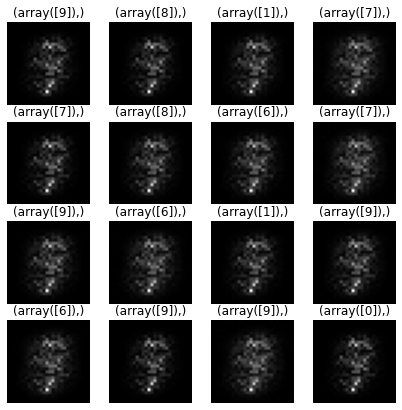

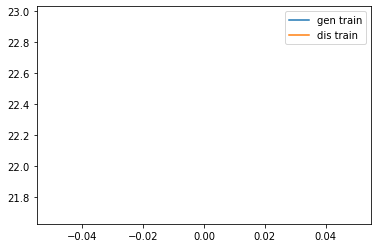

time: 8.656636714935303 
Epoch: 1, Gen[train]: 2.388758897781372, Dis[train]: 2.3669772148132324, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 2, Gen[train]: 2.9072189331054688, Dis[train]: 1.6059975624084473, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 3, Gen[train]: 3.3256804943084717, Dis[train]: 1.4396893978118896, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 4, Gen[train]: 3.493176221847534, Dis[train]: 1.6860096454620361, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 5, Gen[train]: 3.2140469551086426, Dis[train]: 1.5113253593444824, Gen[test]: 0.0, Dis[test]: 0.0 


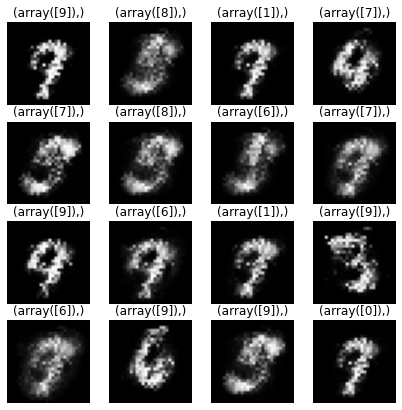

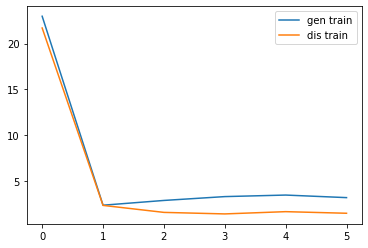

time: 18.806785583496094 
Epoch: 6, Gen[train]: 2.6919326782226562, Dis[train]: 1.5751564502716064, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 7, Gen[train]: 2.4597175121307373, Dis[train]: 1.8812527656555176, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 8, Gen[train]: 2.8686630725860596, Dis[train]: 2.070016860961914, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 9, Gen[train]: 2.9916248321533203, Dis[train]: 2.4357569217681885, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 10, Gen[train]: 2.618417501449585, Dis[train]: 1.9825787544250488, Gen[test]: 0.0, Dis[test]: 0.0 


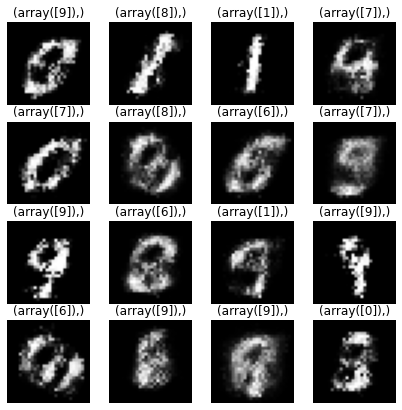

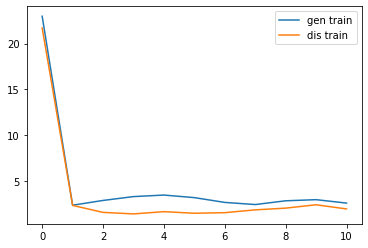

time: 28.664317846298218 
Epoch: 11, Gen[train]: 2.285871982574463, Dis[train]: 1.9356704950332642, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 12, Gen[train]: 4.438188076019287, Dis[train]: 1.9290430545806885, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 13, Gen[train]: 2.312931537628174, Dis[train]: 2.233253240585327, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 14, Gen[train]: 2.298678398132324, Dis[train]: 1.8465592861175537, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 15, Gen[train]: 2.3548336029052734, Dis[train]: 2.355250120162964, Gen[test]: 0.0, Dis[test]: 0.0 


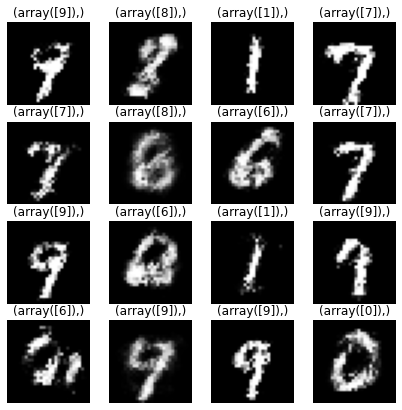

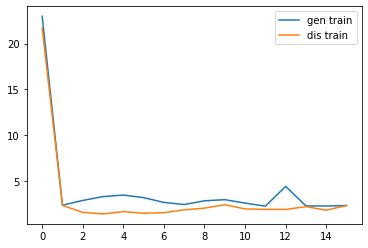

time: 38.83799505233765 
Epoch: 16, Gen[train]: 2.142949104309082, Dis[train]: 2.5936100482940674, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 17, Gen[train]: 1.9651763439178467, Dis[train]: 2.296555995941162, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 18, Gen[train]: 2.4362571239471436, Dis[train]: 2.668760061264038, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 19, Gen[train]: 2.2419376373291016, Dis[train]: 2.405337333679199, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 20, Gen[train]: 2.184272289276123, Dis[train]: 2.581082820892334, Gen[test]: 0.0, Dis[test]: 0.0 


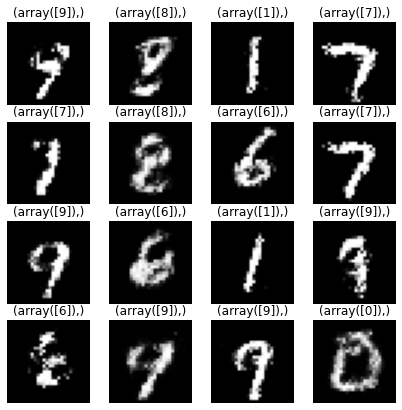

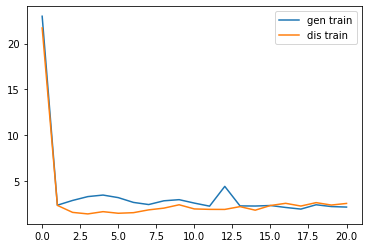

time: 48.465054988861084 
Epoch: 21, Gen[train]: 2.0065417289733887, Dis[train]: 2.5480451583862305, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 22, Gen[train]: 1.8099644184112549, Dis[train]: 2.365326166152954, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 23, Gen[train]: 1.7994976043701172, Dis[train]: 2.4412734508514404, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 24, Gen[train]: 2.0342705249786377, Dis[train]: 2.6471078395843506, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 25, Gen[train]: 2.251934289932251, Dis[train]: 2.720066785812378, Gen[test]: 0.0, Dis[test]: 0.0 


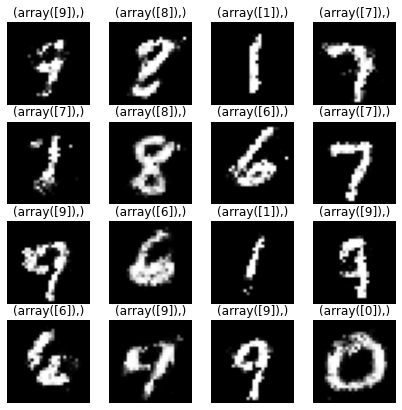

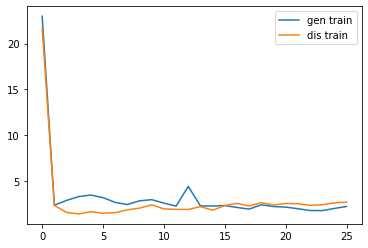

time: 58.35338807106018 
Epoch: 26, Gen[train]: 1.4825221300125122, Dis[train]: 2.125105857849121, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 27, Gen[train]: 2.2914373874664307, Dis[train]: 2.9902586936950684, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 28, Gen[train]: 1.7367626428604126, Dis[train]: 2.479633092880249, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 29, Gen[train]: 2.067086696624756, Dis[train]: 2.755467653274536, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 30, Gen[train]: 1.817124605178833, Dis[train]: 2.255497694015503, Gen[test]: 0.0, Dis[test]: 0.0 


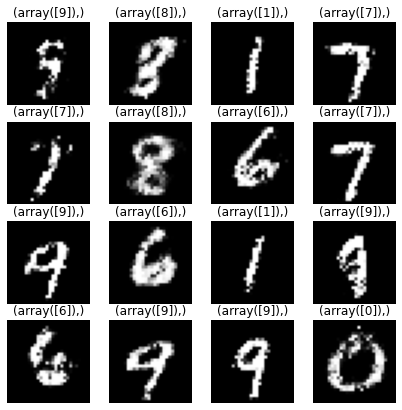

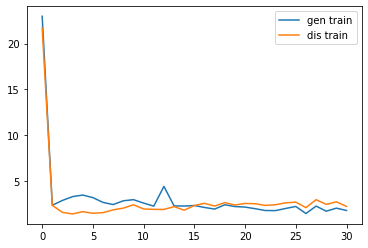

time: 68.11874294281006 
Epoch: 31, Gen[train]: 1.8502668142318726, Dis[train]: 2.5414445400238037, Gen[test]: 0.0, Dis[test]: 0.0 


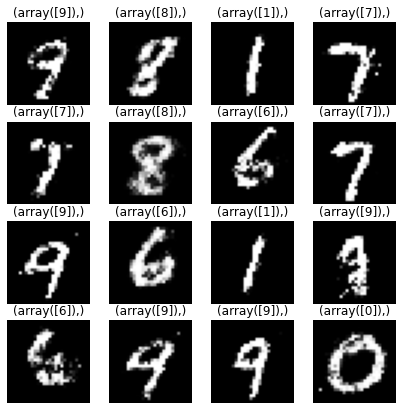

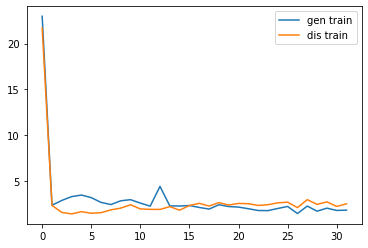

time: 70.94115662574768 
Epoch: 32, Gen[train]: 1.807490587234497, Dis[train]: 2.427582263946533, Gen[test]: 0.0, Dis[test]: 0.0 


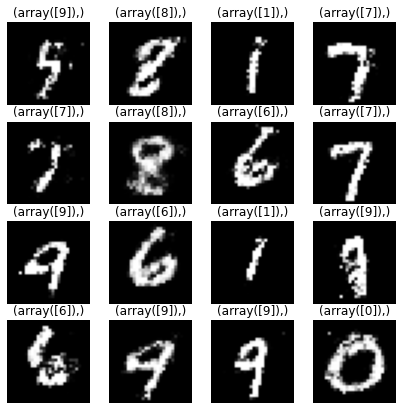

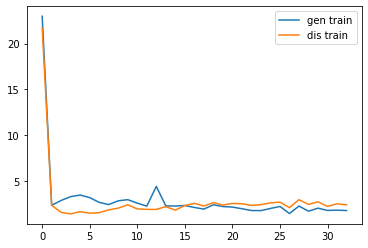

time: 74.10585761070251 
Epoch: 33, Gen[train]: 2.6132314205169678, Dis[train]: 2.96252179145813, Gen[test]: 0.0, Dis[test]: 0.0 


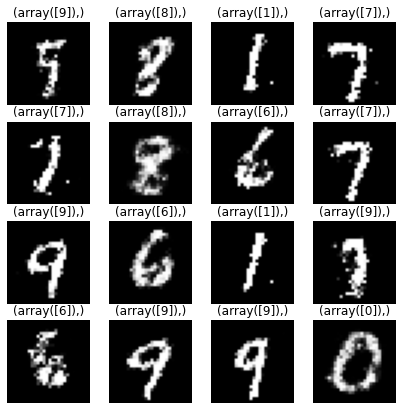

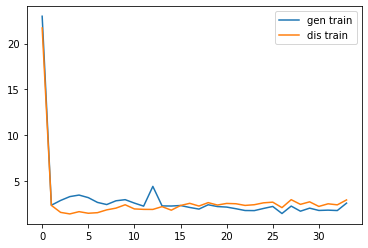

time: 76.94422960281372 
Epoch: 34, Gen[train]: 1.8722621202468872, Dis[train]: 2.7286171913146973, Gen[test]: 0.0, Dis[test]: 0.0 


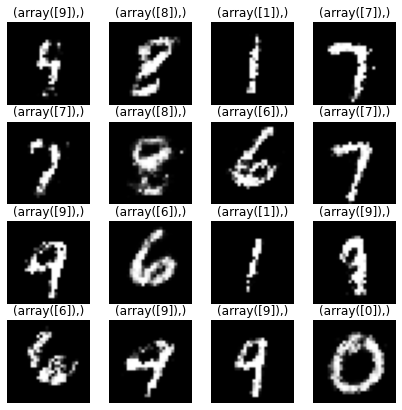

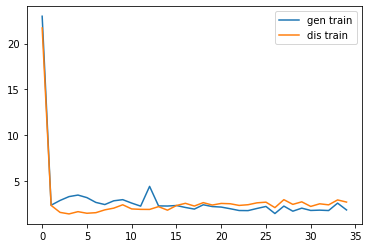

time: 79.90032577514648 
Epoch: 35, Gen[train]: 1.859217882156372, Dis[train]: 2.714186191558838, Gen[test]: 0.0, Dis[test]: 0.0 


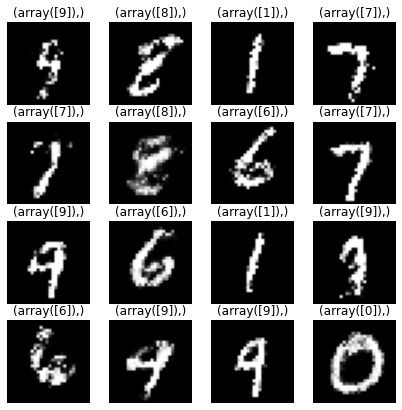

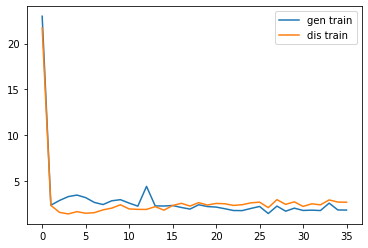

time: 82.7551600933075 
Epoch: 36, Gen[train]: 1.6586225032806396, Dis[train]: 2.64778995513916, Gen[test]: 0.0, Dis[test]: 0.0 


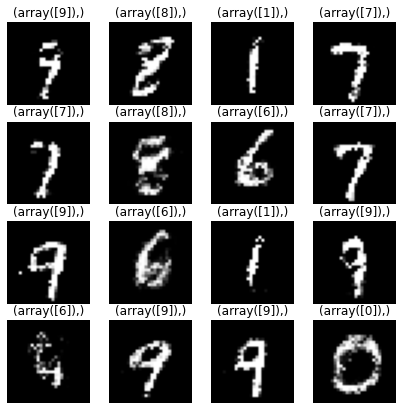

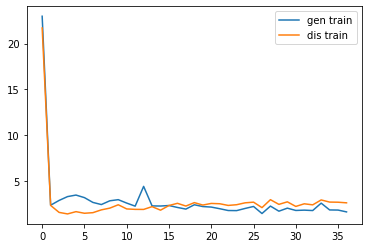

time: 85.56564211845398 
Epoch: 37, Gen[train]: 1.9485275745391846, Dis[train]: 2.6855573654174805, Gen[test]: 0.0, Dis[test]: 0.0 


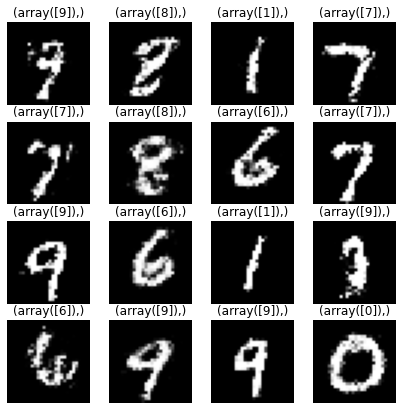

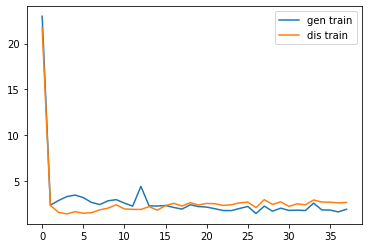

time: 88.66148352622986 
Epoch: 38, Gen[train]: 1.9699490070343018, Dis[train]: 3.0752506256103516, Gen[test]: 0.0, Dis[test]: 0.0 


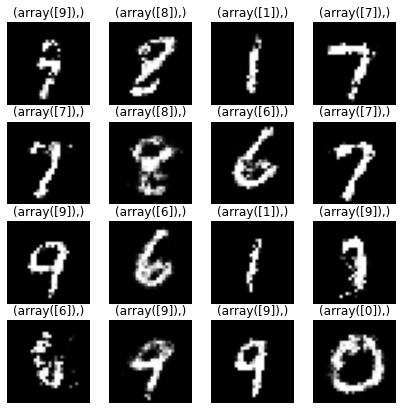

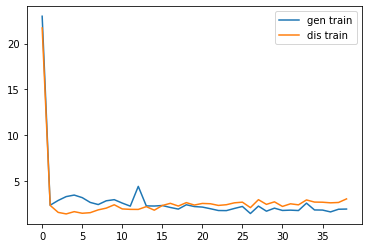

time: 91.37609505653381 
Epoch: 39, Gen[train]: 1.676527738571167, Dis[train]: 2.932628870010376, Gen[test]: 0.0, Dis[test]: 0.0 


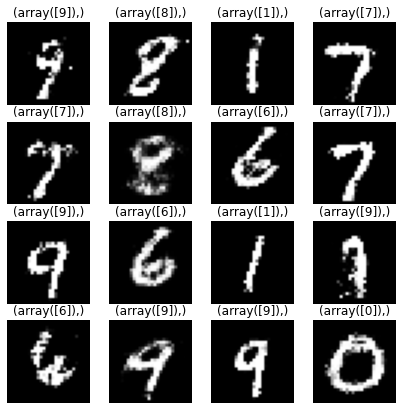

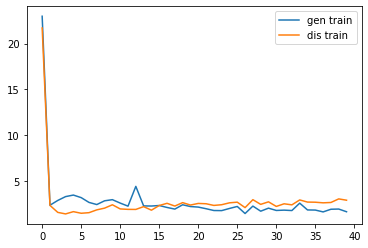

time: 94.21421122550964 
Epoch: 40, Gen[train]: 1.8241297006607056, Dis[train]: 2.7483341693878174, Gen[test]: 0.0, Dis[test]: 0.0 


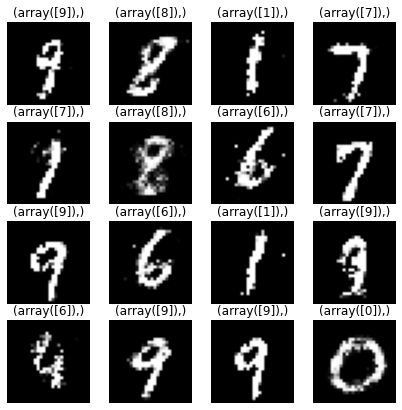

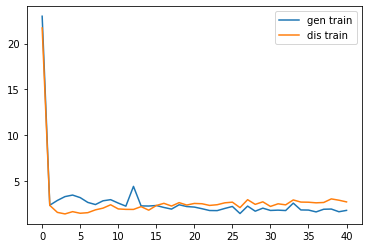

time: 97.32854342460632 
Epoch: 41, Gen[train]: 1.857041358947754, Dis[train]: 2.4492781162261963, Gen[test]: 0.0, Dis[test]: 0.0 


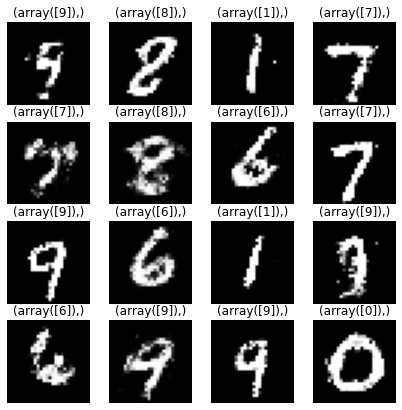

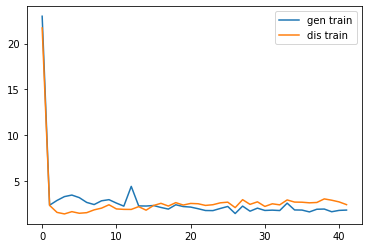

time: 100.4292140007019 
Epoch: 42, Gen[train]: 2.23400616645813, Dis[train]: 2.9345903396606445, Gen[test]: 0.0, Dis[test]: 0.0 


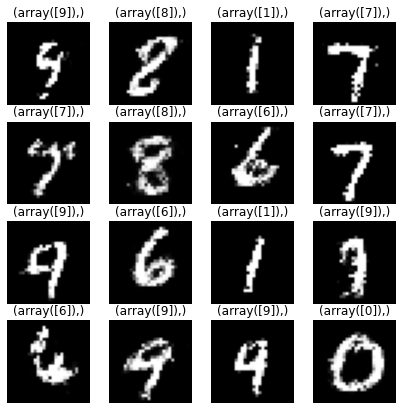

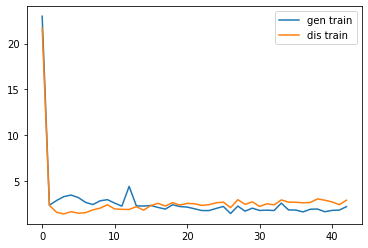

time: 103.50672698020935 
Epoch: 43, Gen[train]: 1.9767305850982666, Dis[train]: 2.877633571624756, Gen[test]: 0.0, Dis[test]: 0.0 


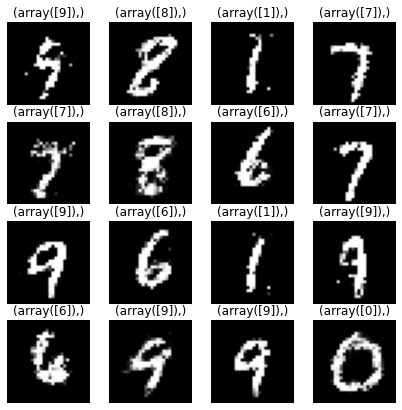

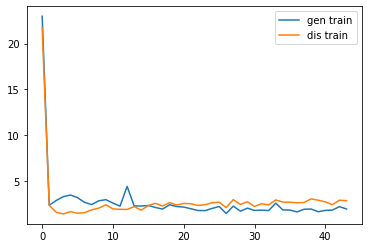

time: 106.37127900123596 
Epoch: 44, Gen[train]: 1.8843125104904175, Dis[train]: 2.796619415283203, Gen[test]: 0.0, Dis[test]: 0.0 


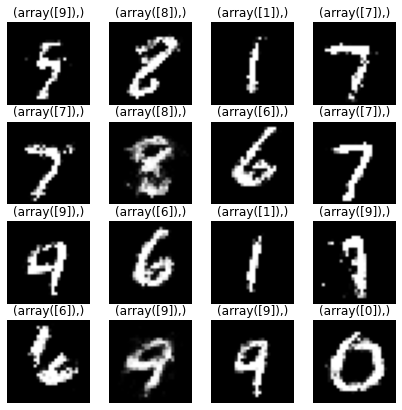

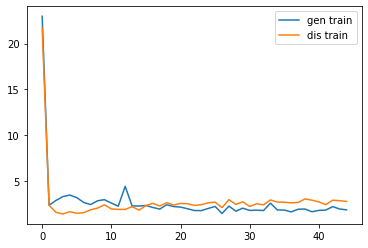

time: 109.35997653007507 
Epoch: 45, Gen[train]: 2.151698112487793, Dis[train]: 2.96309232711792, Gen[test]: 0.0, Dis[test]: 0.0 


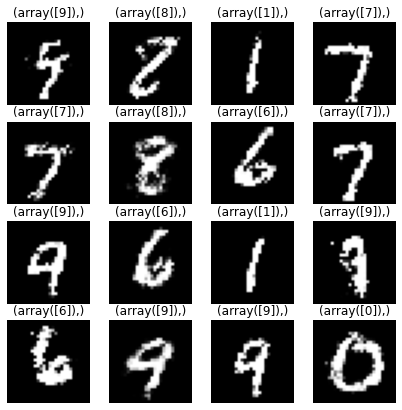

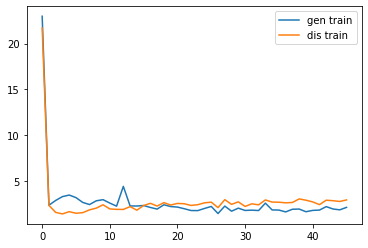

time: 112.37169742584229 
Epoch: 46, Gen[train]: 1.7687360048294067, Dis[train]: 2.5417916774749756, Gen[test]: 0.0, Dis[test]: 0.0 


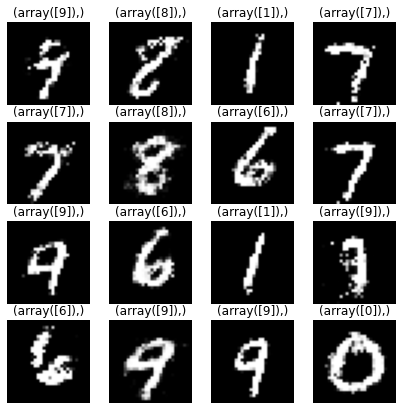

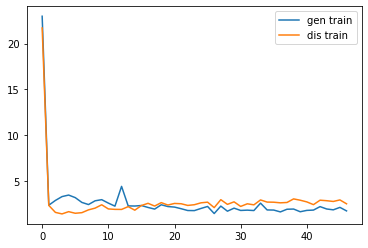

time: 115.31121683120728 
Epoch: 47, Gen[train]: 2.0021393299102783, Dis[train]: 2.887444019317627, Gen[test]: 0.0, Dis[test]: 0.0 


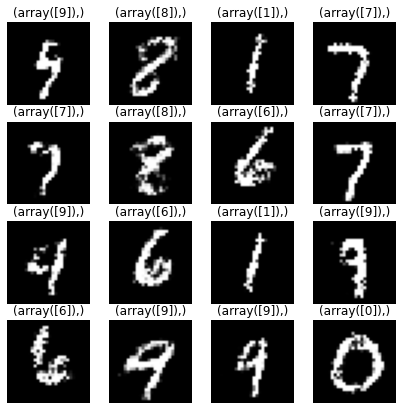

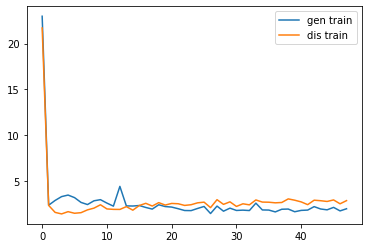

time: 118.18052768707275 
Epoch: 48, Gen[train]: 1.9777567386627197, Dis[train]: 2.7805888652801514, Gen[test]: 0.0, Dis[test]: 0.0 


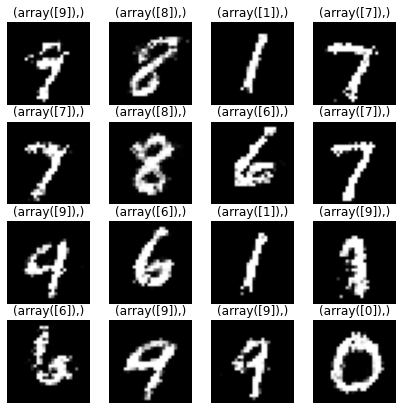

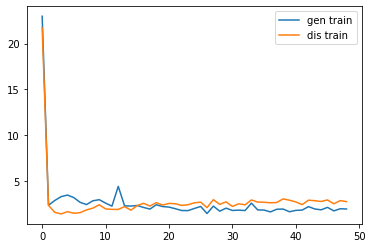

time: 121.146639585495 
Epoch: 49, Gen[train]: 2.032532215118408, Dis[train]: 2.7241570949554443, Gen[test]: 0.0, Dis[test]: 0.0 


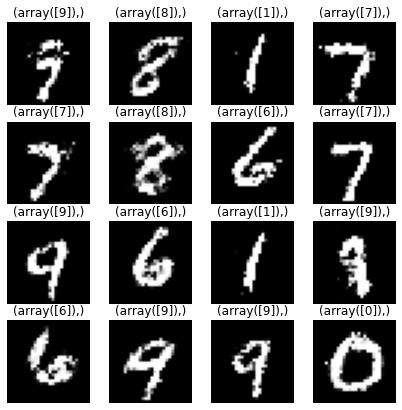

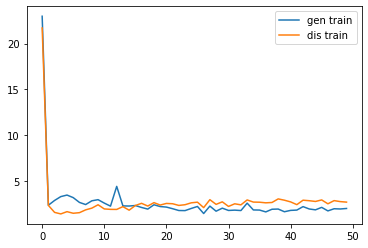

time: 123.83821415901184 


In [16]:
import time
display_step = 5
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
noise_seed = np.random.uniform(-1, 1, size=[num_examples_to_generate, noise_dim])

arr = []
for i in range(16):
  rand_label = np.random.randint(0, 10)
  rand_label = to_categorical(rand_label, 10)
  arr.append(rand_label)

arr = np.array(arr)

train_range = 50
gen_loss_arr = []
dis_loss_arr = []
gen_tloss_arr = []
dis_tloss_arr = []
EPOCH=[]

strat_time = time.time()
for epoch in range(train_range):
  i = 0
  for x_batch in train_data:
    real = y_train[i*batch_size:(i+1)*batch_size]
    if real.shape[0] != 256:
      break;
    gen_loss, dis_loss = gen_network.train(x_batch[0], real)
    train_gen_loss(gen_loss)
    train_dis_loss(dis_loss)
    i +=1
  
  for x_batch in test_data:
    real = y_test[i*batch_size:(i+1)*batch_size]
    if real.shape[0] != 256:
      break;
    a,b, loss_gen_t, loss_dis_t = gen_network.compute_gradient(x_batch[0], real)
    test_gen_loss(loss_gen_t)
    test_dis_loss(loss_dis_t)
    i += 1
  

  gen_loss_arr.append(train_gen_loss.result())
  dis_loss_arr.append(train_dis_loss.result())
  gen_tloss_arr.append(test_gen_loss.result())
  dis_tloss_arr.append(test_dis_loss.result())
  EPOCH.append(epoch)

  print(f'Epoch: {epoch}, Gen[train]: {train_gen_loss.result()}, Dis[train]: {train_dis_loss.result()}, Gen[test]: {test_gen_loss.result()}, Dis[test]: {test_dis_loss.result()} ')

  if epoch % display_step == 0 or epoch >= 30:
    show_generated_img(gen_network, epoch + 1, noise_seed, (arr*1.0))
    show_loss(gen_loss_arr, dis_loss_arr, gen_tloss_arr, dis_tloss_arr, EPOCH)
    print(f'time: {time.time() - strat_time} ')

  train_gen_loss.reset_states()
  train_dis_loss.reset_states()
  test_gen_loss.reset_states()
  test_dis_loss.reset_states()

In [17]:
arr = []
for i in range(16):
    rand_label = np.random.randint(0, 10)
    rand_label = to_categorical(rand_label, 10)
    arr.append(rand_label)

a = np.array(arr)
a.all()

False